In [1]:
import nilearn
from nilearn import plotting
from nilearn import datasets
from nilearn.image import mean_img
from nilearn import image
import numpy as np
import pandas as pd
import os
from nilearn.datasets import MNI152_FILE_PATH
from nilearn.image import math_img


/Users/ananogueira/.local/lib/python3.8/site-packages/nilearn/datasets/__init__.py:87: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


os.getcwd()

DADOS FUNCIONAIS 

ver pré-procesamento do FSL

(91, 109, 91, 125)


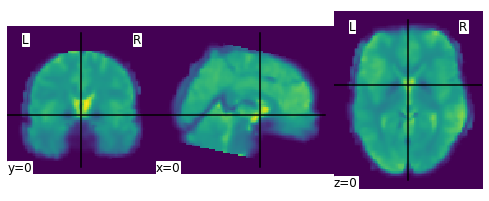

In [65]:
cut_coords=(0, 0, 0)
func_data_preproc='/Users/ananogueira/Desktop/Documents/DATA_ananogueira/func/sub-0001_ses-001_task-nomeacaoinner_run-01_bold_pp_standard.nii.gz'
mean_fmri_img=mean_img(func_data_preproc)
plotting.plot_img(mean_fmri_img, cut_coords)
print(image.load_img(func_data_preproc).shape)

Dados alinhados, também representa a média de todos os volumes funcionais

Terminou o pré-processamento de dados.
Temos 125 volumes.

DESIGN MATRIX

Definir os momentos em que a pessoa estava a fazer alguma coisa e os momentos em que a pessoa estava a descansar



In [4]:
from nilearn.glm.first_level import make_first_level_design_matrix
from nilearn.plotting import plot_design_matrix

tr = 3  # repetition time is ? second 
n_scans = 125  # the acquisition comprises ?? scans
frame_times = np.arange(n_scans) * tr  # here are the correspoding frame times

# load events.tsv
events_PATH='/Users/ananogueira/Desktop/Documents/DATA_ananogueira/func/sub-0001_ses-001_task-nomeacaoinner_run-01_events.tsv'

events_df = pd.read_csv(events_PATH, sep='\t', na_values="n/a")
print(events_df.head())



   trial_type  onset  duration
0           0      0         3
1           0      3         3
2           0      6         3
3           0      9         3
4           0     12         3


Está pronto para extrair o beta serius, que nos permite minimizar o impacto da resposta hemodinâmica. 

Informação do que a pessoa estava a fazer em determinado tempo

<AxesSubplot:label='conditions', ylabel='scan number'>

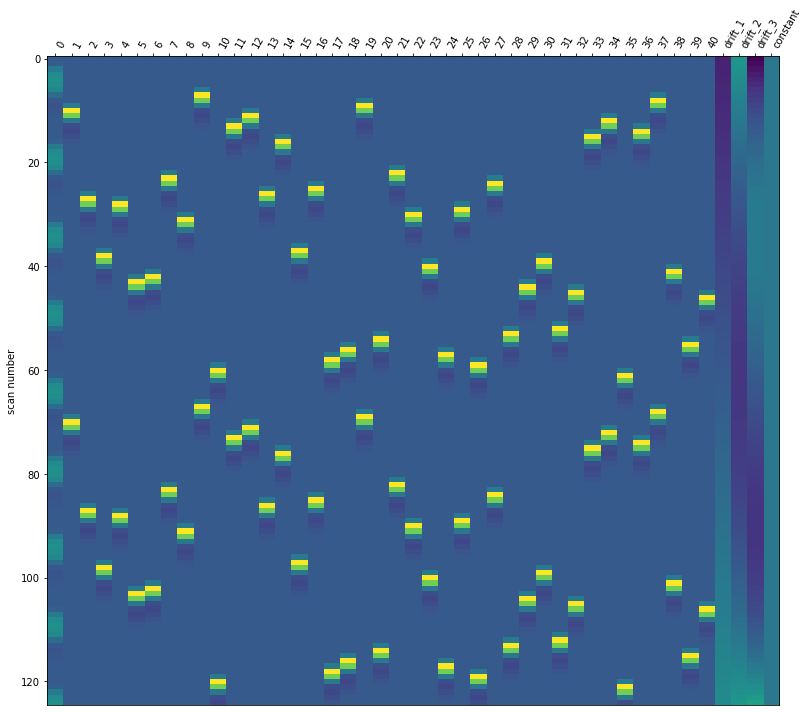

In [5]:
hrf_model='spm'
design_matrix = make_first_level_design_matrix(frame_times, events_df,
                                    drift_model='polynomial', drift_order=3,
                                    hrf_model=hrf_model)
plot_design_matrix(design_matrix)

Temos 40 imagens diferentes. Cada uma das imagens é apresentada ao sujeito duas vezes.

Para cada um dos momentos ao longo do tempo há um preditor

In [6]:
events_bs=events_df.copy()
events_bs['trial_type']=range(len(events_bs))

print(events_bs)

     trial_type  onset  duration
0             0      0         3
1             1      3         3
2             2      6         3
3             3      9         3
4             4     12         3
..          ...    ...       ...
120         120    360         3
121         121    363         3
122         122    366         3
123         123    369         3
124         124    372         3

[125 rows x 3 columns]


<AxesSubplot:label='conditions', ylabel='scan number'>

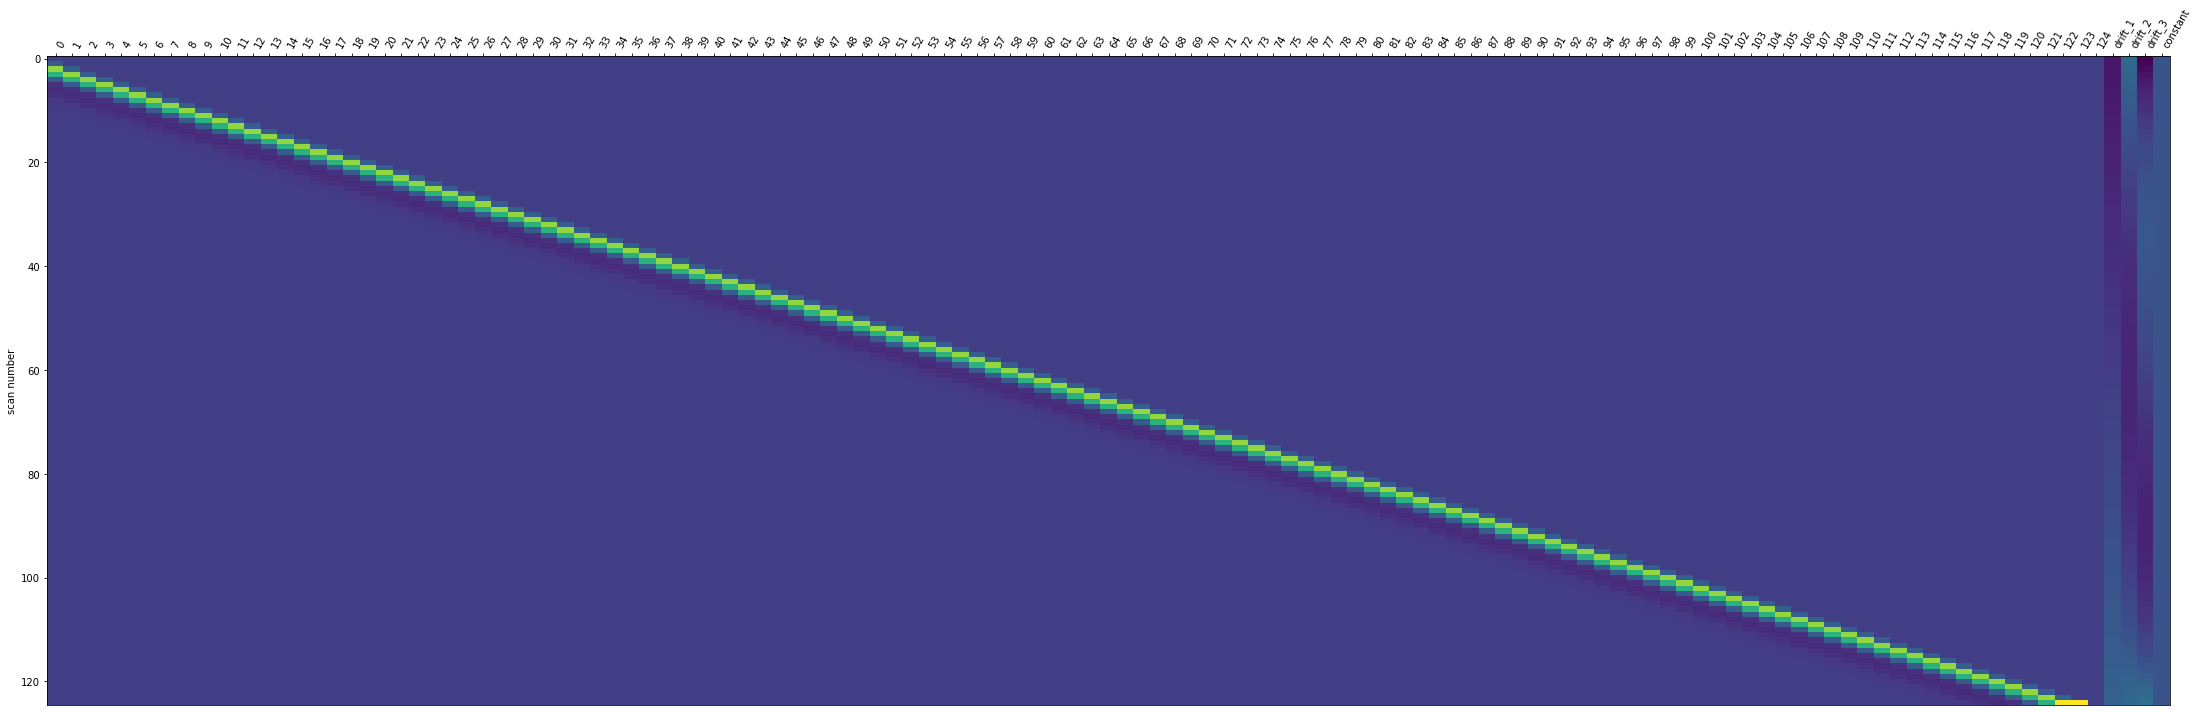

In [7]:
design_matrix_bs = make_first_level_design_matrix(frame_times, events_bs,
                                    drift_model='polynomial', drift_order=3,
                                    hrf_model=hrf_model)
plot_design_matrix(design_matrix_bs)

 
 ESTATISTICA DE PRIMEIRA ORDEM
 
Comportamento do voxel ao longo do tempo 


In [9]:
contrast_matrix = np.eye(design_matrix_bs.shape[1])
basic_contrasts = dict([(column, contrast_matrix[i])
                        for i, column in enumerate(design_matrix.columns)])


In [13]:
from nilearn.glm.first_level import FirstLevelModel

print('Fitting a GLM')
fmri_glm = FirstLevelModel()
fmri_glm.fit(func_data_preproc, design_matrices=design_matrix_bs)

Fitting a GLM


FirstLevelModel(signal_scaling=True)

In [14]:
z_maps=[]
for contrast in basic_contrasts:
    z_maps.append(fmri_glm.compute_contrast(basic_contrasts[contrast], output_type='z_score'))

/Users/ananogueira/.local/lib/python3.8/site-packages/nilearn/glm/model.py:216: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))



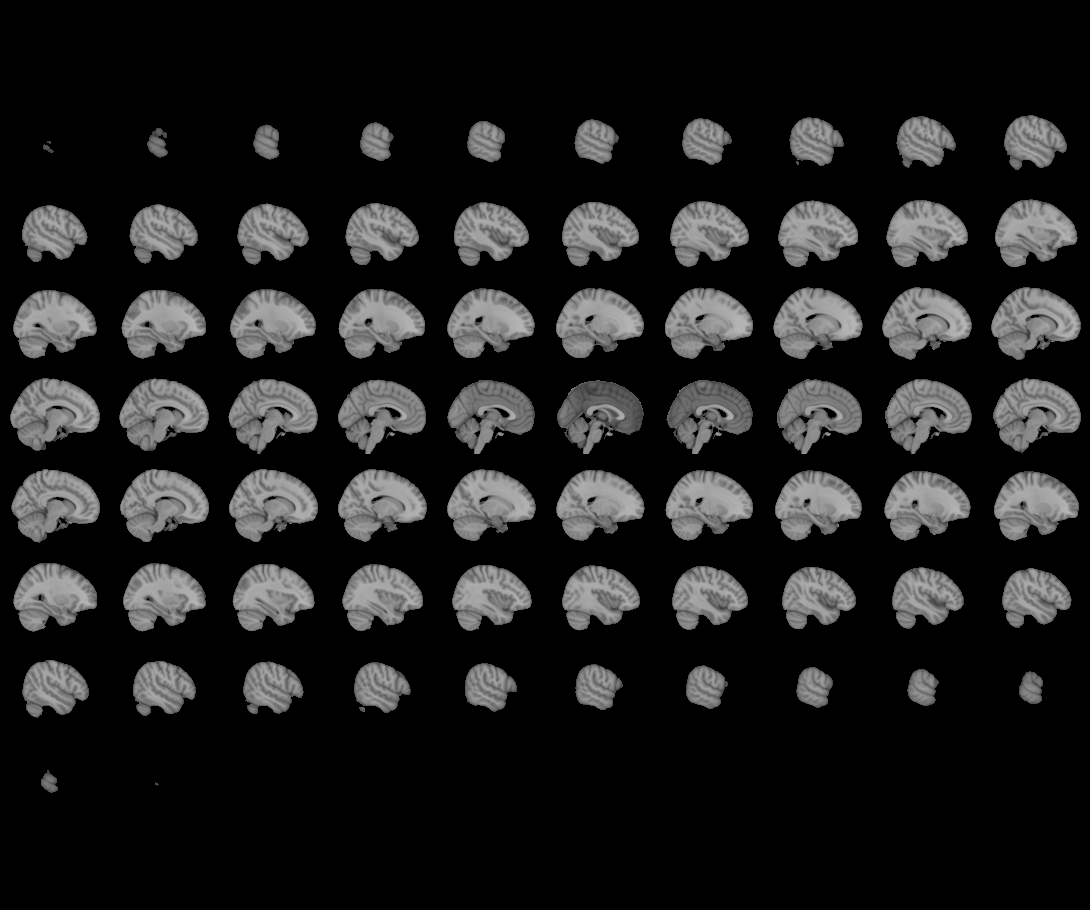
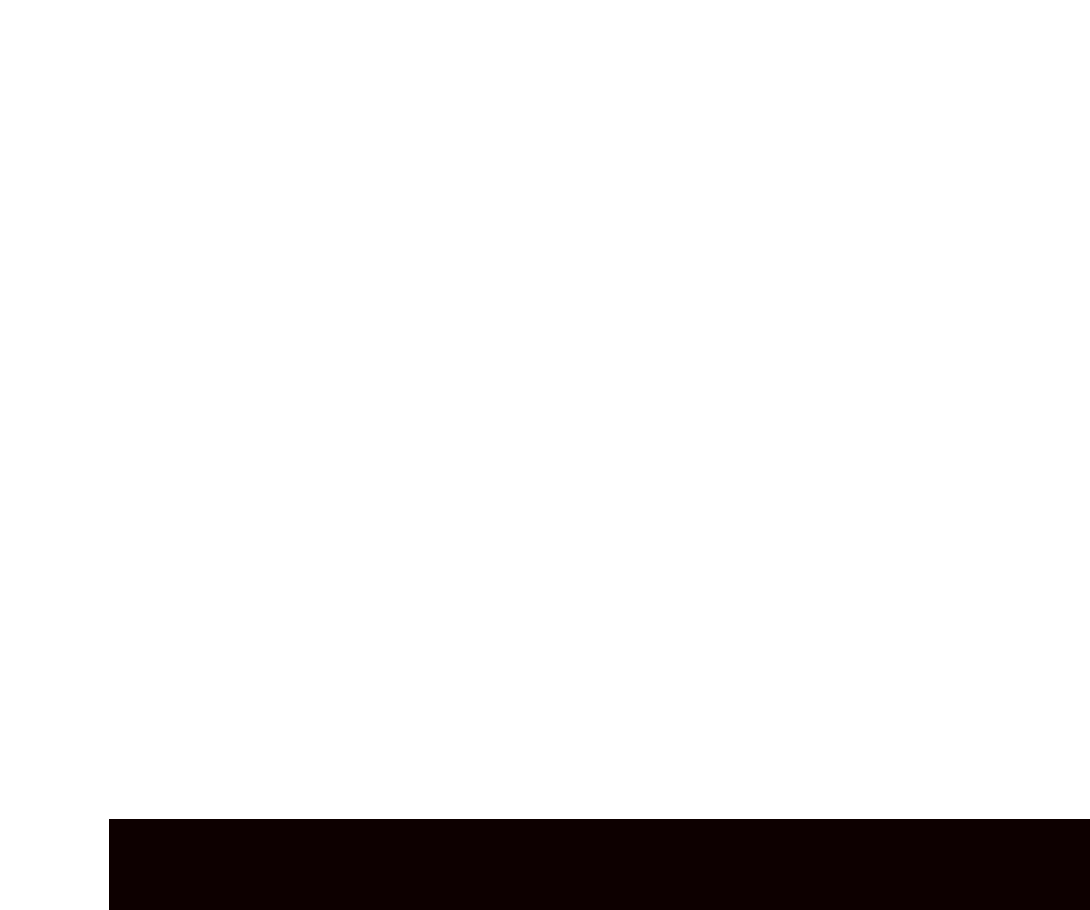

In [25]:
from nilearn import datasets



dataset = datasets.fetch_atlas_harvard_oxford('cort-maxprob-thr25-2mm') 
atlas_filename = dataset.maps


brain_mask = mean_img([math_img('img == %d'  %i, img=atlas_filename) for i in [48, 49]])
plotting.view_img(brain_mask)

In [26]:
from nilearn.decoding import Decoder 
decoder = Decoder(estimator='svc', mask=brain_mask) 



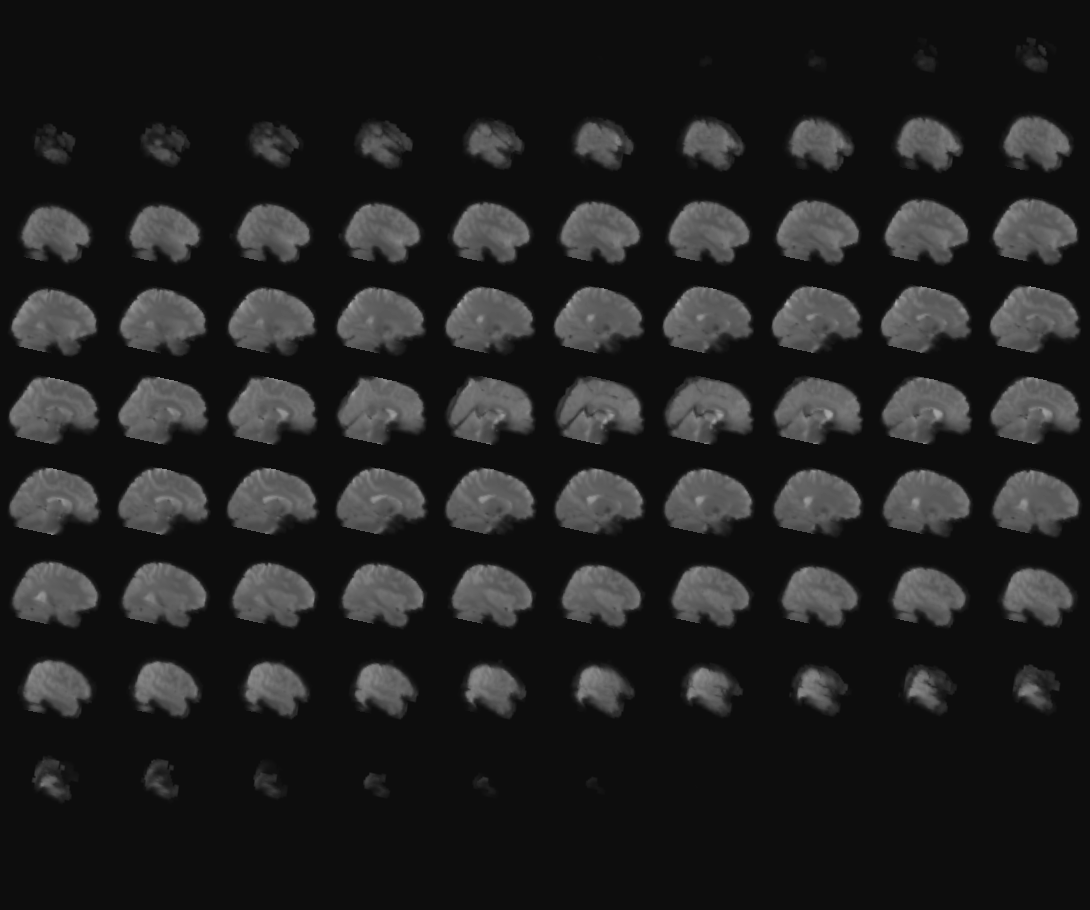
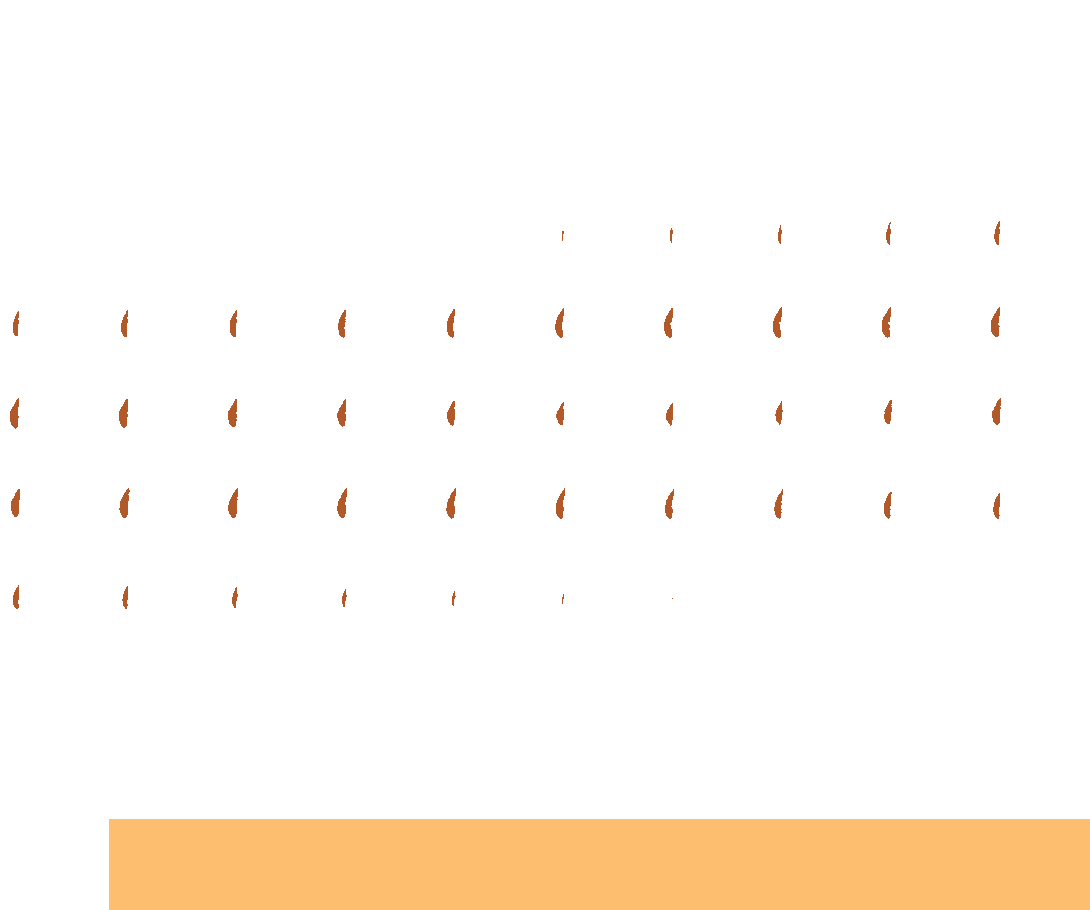

In [27]:
plotting.view_img(brain_mask, bg_img=mean_fmri_img,
                  cmap='Paired')

In [28]:

conditions=events_df['trial_type']


In [29]:
len(conditions)
print(conditions)

0      0
1      0
2      0
3      0
4      0
      ..
120    0
121    0
122    0
123    0
124    0
Name: trial_type, Length: 125, dtype: int64


CROSS VALIDATION 

In [58]:
print(events_df)

     trial_type  onset  duration
0             0      0         3
1             0      3         3
2             0      6         3
3             0      9         3
4             0     12         3
..          ...    ...       ...
120           0    360         3
121           0    363         3
122           0    366         3
123           0    369         3
124           0    372         3

[125 rows x 3 columns]


In [68]:
idxs=events_df['onset']/tr
conditions = []

for i in range(len(events_df)):
    idx_2=((events_df['duration'][i]/tr))+1
    for j in range(int(idx_2)):
        conditions.append(events_df['trial_type'][i])

In [69]:
print(conditions)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 19, 19, 17, 17, 20, 20, 35, 35, 22, 22, 36, 36, 26, 26, 12, 12, 37, 37, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 7, 8, 8, 38, 38, 33, 33, 32, 32, 16, 16, 11, 11, 15, 15, 28, 28, 21, 21, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 6, 2, 2, 3, 3, 30, 30, 27, 27, 18, 18, 14, 14, 25, 25, 31, 31, 40, 40, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 5, 24, 24, 23, 23, 34, 34, 39, 39, 4, 4, 9, 9, 1, 1, 29, 29, 13, 13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 19, 19, 17, 17, 20, 20, 35, 35, 22, 22, 36, 36, 26, 26, 12, 12, 37, 37, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 7, 8, 8, 38, 38, 33, 33, 32, 32, 16, 16, 11, 11, 15, 15, 28, 28, 21, 21, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 6, 2, 2, 3, 3, 30, 30, 27, 27, 18, 18, 14, 14, 25, 25, 31, 31, 40, 40, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 5, 24, 24, 23, 23, 34, 34, 39, 39, 4, 4, 9, 9, 1, 1, 29, 29, 13, 13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [70]:
fmri_niiimgs=image.load_img('/Users/ananogueira/Desktop/Documents/DATA_ananogueira/func/sub-0001_ses-001_task-nomeacaoinner_run-01_bold_pp_standard.nii.gz'
)
fmri_niiimgs.shape

(91, 109, 91, 125)

In [72]:
from nilearn.image import index_img
trainset = index_img(fmri_niiimgs, slice(0, -50))
trainset.shape

(91, 109, 91, 75)

In [73]:
testset = index_img(fmri_niiimgs, slice(-50,None))
testset.shape

(91, 109, 91, 50)